## Imports

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from PIL import Image

## Pathway(s)

In [4]:
data_path = '../Data/train'

## Data Prep

In [5]:
filenames = os.listdir(data_path)
labels = []

In [6]:
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append(1) #1 for dog
    else:
        labels.append(0) #0 for gat-0

In [7]:
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df.sample(10)

,filename,label
8632,cat.112.jpg,0
20870,dog.384.jpg,1
2434,dog.10342.jpg,1
2331,cat.2848.jpg,0
20370,dog.5271.jpg,1
3748,dog.6614.jpg,1
1148,cat.3017.jpg,0
9668,dog.8276.jpg,1
4044,dog.10353.jpg,1
3500,dog.1594.jpg,1


In [8]:
df['label'].value_counts()

1    12500
0    12500
Name: label, dtype: int64

*Nice* This makes my life waaaay easier

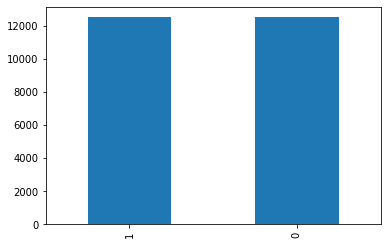

In [9]:
df['label'].value_counts().plot.bar()

I'll make something prettier wiht seaborn later

In [10]:
from PIL import Image

Time to get the average image sizes for future use

In [11]:
for filename in filenames:
    
    width = []
    height = []
    
    img_path = os.path.join(data_path, filename)
    im = Image.open(img_path)
    
    w, h = im.size
    
    width.append(w)
    height.append(h)
    
w_avg = sum(width)/len(width)
h_avg = sum(height)/len(height)
    
print(w_avg, h_avg)

499.0 375.0


PS: If you are looking over my code and re-running all of it the cell above will take a minute or two

Now that this is done, I'll start getting the fsm ready

## FSM

I'm going to start small and not make a super complex model for the FSM, but I am going to try out spme new things friends have told me about

### setup

In [53]:
width = int(w_avg)
height = int(h_avg)
img_size = ((width, height))
batch_size = 32

In [56]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

call_backs = [earlystop, learning_rate_reduction]

import tensorflow as tf
import tensorflow.keras.preprocessing as preprocessing
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
type()

In [14]:
df['label'] = df['label'].replace({0:'cat', 1:'dog'})

In [15]:
X_t, v_t = train_test_split(df, test_size = 0.15,  random_state = 7)
X_t = X_t.reset_index(drop = True)
v_t = v_t.reset_index(drop=True)

In [18]:
X_t['label'].value_counts()

dog    10629
cat    10621
Name: label, dtype: int64

In [19]:
v_t['label'].value_counts()

cat    1879
dog    1871
Name: label, dtype: int64

Close enough

### generators

In [33]:
img_gen = ImageDataGenerator(rescale = 1./255., horizontal_flip = True) #keeping it simple for now

train_generator = img_gen.flow_from_dataframe(
    X_t,
    data_path,
    x_col = 'filename',
    y_col = 'label',
    target_size = (499, 375),
    batch_size = batch_size,
    class_mode ='categorical'
)

val_img_gen = ImageDataGenerator(rescale = 1./255.) #keeping it simple for now

val_generator = img_gen.flow_from_dataframe(
    v_t,
    data_path,
    x_col = 'filename',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode ='categorical'
)

Found 21250 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.


### model

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

fsm = Sequential() 
fsm.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (width, height, 3)))#3 for rgb
fsm.add(MaxPooling2D(pool_size=(2, 2)))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Conv2D(64, (3, 3), activation = 'relu'))
fsm.add(MaxPooling2D((2, 2)))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Conv2D(128, (3, 3), activation = 'relu'))
fsm.add(MaxPooling2D((2, 2)))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Flatten())
fsm.add(Dense(64, activation='relu'))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Dense(128, activation='relu'))
fsm.add(BatchNormalization())
fsm.add(Dropout(0.20))

fsm.add(Dense(2, activation='softmax')) #2 for cat or dog (or based or cringe)
fsm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

fsm.summary()

W1105 14:51:11.393599 4504341952 deprecation_wrapper.py:119] From /Users/adamroth/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 497, 373, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 248, 186, 32)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 248, 186, 32)      128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 248, 186, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 246, 184, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 92, 64)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 123, 92, 64)       256       
__________

In [60]:
history_fsm = fsm.fit_generator(
    train_generator, 
    epochs = 30,
    validation_data = val_generator,
    validation_steps = 20,
    steps_per_epoch = 100,
    callbacks = call_backs
)

W1105 15:06:05.225548 4504341952 deprecation.py:323] From /Users/adamroth/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
 99/100 [============================>.] - ETA: 12s - loss: 0.8557 - acc: 0.5593

TypeError: 'float' object cannot be interpreted as an integer

In [57]:
def vis_history(history): 
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()